# 04 - Modelagem

<a href="../README.md" title="Voltar para a página principal">
🏠 Voltar para Home
</a>

## 🎯 Visão Geral

Este notebook marca o início da fase de **modelagem preditiva**, utilizando modelos clássicos de Machine Learning para estabelecer um baseline sólido antes de avançar para algoritmos mais sofisticados.

Aqui começamos a responder à pergunta central do projeto:

> **“Com base nas informações operacionais, conseguimos prever se um pedido irá atrasar (fl_atraso_cli)?”**

Para isso, utilizamos os dados já tratados e enriquecidos (Feature Engineering) nos notebooks anteriores:

- `00_eda_tratamento.ipynb`  
- `01_eda_descritiva.ipynb`  
- `02_eda_inferencial.ipynb`  
- `03_preprocessing_pipeline.ipynb`  

---

## 📌 Objetivos deste Notebook

Este notebook implementa:

1. **Modelo Baseline (DummyClassifier)**  
   - estabelece uma linha de comparação mínima para avaliar se os modelos realmente têm poder preditivo.

2. **Modelos Clássicos de Classificação**
   - **Regressão Logística**  
   - **Árvore de Decisão (Decision Tree Classifier)**  

3. **Integração com o Pipeline de Pré-processamento**  
   - garante que imputação, codificação e escala sejam aplicadas corretamente dentro de cada modelo.

4. **Validação e Métricas**
   - Accuracy
   - Precision
   - Recall
   - F1-score
   - ROC AUC
   - Classification Report
   - Matriz de Confusão

5. **Comparação entre modelos**
   - para selecionar o melhor candidato a ser refinado no notebook 05 (modelos avançados).

# Importações

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)


from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

# 1. Carregamento e Visualização Preliminar

***Descrição:*** Utilizando o dataset de acompanhamento operacional dos pedidos tratados.
> **Arquivo e:** database/processed/acompanhamento_operacional_FE.csv

In [40]:
file_path = "../database/processed/acompanhamento_operacional_FE.csv"

df = pd.read_csv(file_path)

print("Dataset carregado com sucesso!")
print("Formato:", df.shape)
df.head()

Dataset carregado com sucesso!
Formato: (488398, 29)


,sigla_cliente,tipo_veiculo,qtde_itens,volume,peso,m3,uf,fl_base,representante,flag_entrega_agendada,...,horas_conferencia,horas_emissao,horas_analise_producao,horas_minuta,horas_exped_minuta,hora_analise_transporte,lead_time_total_horas,complexidade_operacional,pedido_grande_flag,processo_longo_flag
0,NTL,TRUCK 70 M3,1,1,144.30,2.10,MS,0,NÃO DEFINIDO,Não,...,0.0,0.0,22.0,0.0,16.0,161.0,229.0,1,0,0
1,NTL,TRUCK 70 M3,1,1,130.30,2.33,MS,0,NÃO DEFINIDO,Não,...,0.0,0.0,22.0,0.0,16.0,165.0,234.0,1,0,0
2,NTL,TRUCK 70 M3,1,1,97.00,2.22,SC,0,SC CARGO TRANSPORTES LTDA,Não,...,0.0,0.0,0.0,0.0,16.0,40.0,249.0,1,0,0
3,MMM,TRUCK 75 M3,7,43,182.79,1.08,CE,0,VELOMAX BRASIL TRANSPORTES LTD,Não,...,1.0,0.0,11.0,99.0,8.0,93.0,266.0,7,1,0
4,MMM,TRUCK 70 M3,4,9,25.50,0.07,CE,0,MFM TRANSPORTES,Sim,...,1.0,0.0,12.0,172.0,16.0,285.0,542.0,4,1,1


# 2. Pré-Processamento (scikit-learn)

In [41]:
# 1. Separando Variáveis
TARGET = "fl_atraso_cli"

# Remover target para análise inicial
cols = df.columns.tolist()

num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c != TARGET]

cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Colunas numéricas: ", num_cols)
print("Colunas categóricas: ", cat_cols)

print("----------------------------------------------------------------------------------------------------------------------------")
# 2. Imputação
# Imputação numérica: mediana -> robusta a outliers
numeric_imputer = SimpleImputer(strategy="median")

# Imputação categórica: moda -> mantém consistência
categorical_imputer = SimpleImputer(strategy="most_frequent")

print("Imputadores definidos com sucesso!")

print("----------------------------------------------------------------------------------------------------------------------------")
# 3. Encoding Categórico (OneHotEncoder)
categorical_encoder = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)

print("OneHotEncoder configurado!")

print("----------------------------------------------------------------------------------------------------------------------------")
# 4. Scaling numérico
numeric_scaler = StandardScaler()

print("Scaler definido!")

print("----------------------------------------------------------------------------------------------------------------------------")
# 5. Construção do ColumnTransformer
preprocess = ColumnTransformer(transformers=[
    ("num_pipeline", Pipeline(steps=[
        ("imputer", numeric_imputer),
        ("scaler", numeric_scaler)
    ]), num_cols),

    ("cat_pipeline", Pipeline(steps=[
        ("imputer", categorical_imputer),
        ("encoder", categorical_encoder)
    ]), cat_cols)
])

print("ColumnTransformer criado com sucesso!")

print("----------------------------------------------------------------------------------------------------------------------------")
# 6. Train/Test Split
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Split realizado!")
print("Treino:", X_train.shape)
print("Teste:", X_test.shape)

print("----------------------------------------------------------------------------------------------------------------------------")
# 7. Pipeline Final de Pré-processamento
pipeline_preprocess = Pipeline(steps=[
    ("preprocess", preprocess)
])

print("Pipeline de pré-processamento pronto!")

Colunas numéricas:  ['qtde_itens', 'volume', 'peso', 'm3', 'fl_base', 'qtde_ocams', 'peso_cubado_rodoviario', 'horas_pre_conferencia', 'horas_distribuicao_cotas', 'horas_planejamento', 'horas_divisao_ocam', 'horas_coleta', 'horas_conferencia', 'horas_emissao', 'horas_analise_producao', 'horas_minuta', 'horas_exped_minuta', 'hora_analise_transporte', 'lead_time_total_horas', 'complexidade_operacional', 'pedido_grande_flag', 'processo_longo_flag']
Colunas categóricas:  ['sigla_cliente', 'tipo_veiculo', 'uf', 'representante', 'flag_entrega_agendada', 'modalidade']
----------------------------------------------------------------------------------------------------------------------------
Imputadores definidos com sucesso!
----------------------------------------------------------------------------------------------------------------------------
OneHotEncoder configurado!
------------------------------------------------------------------------------------------------------------------------

# 3. Modelo Baseline - DummyClassifier

**Descrição:** O modelo baseline tem como objetivo estabelecer um ponto de referência mínimo para comparação dos modelos reais.
Neste trabalho, será utilizado o DummyClassifier(strategy="most_frequent"), que sempre prevê a classe majoritária encontrada no dataset.

In [42]:
# Construção do pipeline completo (preprocessamento -> modelo)
dummy_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DummyClassifier(strategy="most_frequent"))
])

# Treinamento
dummy_model.fit(X_train, y_train)

# Predição
y_pred_dummy = dummy_model.predict(X_test)
y_proba_dummy = dummy_model.predict_proba(X_test)[:, 1]

# Avaliação
baseline_results = {
    "Accuracy": accuracy_score(y_test, y_pred_dummy),
    "Precision": precision_score(y_test, y_pred_dummy),
    "Recall": recall_score(y_test, y_pred_dummy),
    "F1": f1_score(y_test, y_pred_dummy),
    "ROC AUC": roc_auc_score(y_test, y_proba_dummy)
}

print("\n======================")
print("RESULTADOS BASELINE")
print("======================")
for metric, value in baseline_results.items():
    print(f"{metric}: {value:.4f}")



RESULTADOS BASELINE
Accuracy: 0.7308
Precision: 0.0000
Recall: 0.0000
F1: 0.0000
ROC AUC: 0.5000


**Nota Técnica:** Esses valores são esperados, já que o modelo nunca prevê “1 = atraso”, apenas repete a classe dominante (0).
O comportamento demonstra, viés extremo para a classe majoritária, incapacidade total de detectar atrasos e desempenho equivalente a uma classificação aleatória (ROC AUC = 0.5)

**Importância do Baseline:** A função do baseline não é prever corretamente, mas sim, estabelecer o ponto mínimo aceitável de desempenho, garantir que um modelo real não seja pior do que adivinhar sempre “não atraso”, servir como referência para medir ganho de performance e deixar explícito o impacto do desbalanceamento da classe alvo.

**Conclusão**

O baseline confirma que o dataset possui forte desbalanceamento, então métricas como precision, recall e F1 serão fundamentais, com isso é provável que qualquer modelo útil deve superar esse resultado, principalmente em recall para a classe "1" (atraso)

Assim, os modelos seguintes devem ser avaliados não apenas por accuracy, mas também por F1, Recall e ROC AUC, que de fato capturam a qualidade da detecção de atrasos.

# 4. Treinando a Regressão Logística (LogisticRegression)

**Descrição:** A regressão logística é uma técnica estatística para prever a probabilidade de um evento ocorrer, com base em variáveis independentes.

In [43]:
# Pipeline completo: preprocessamento + modelo
logreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=500,
        class_weight="balanced",   # importante devido ao desbalanceamento
        solver="lbfgs"
    ))
])

# Treinamento
logreg_pipeline.fit(X_train, y_train)

# Previsões
y_pred = logreg_pipeline.predict(X_test)
y_prob = logreg_pipeline.predict_proba(X_test)[:, 1]

# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

print("=======================")
print("REGRESSÃO LOGÍSTICA")
print("=======================")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")


REGRESSÃO LOGÍSTICA
Accuracy:  0.7083
Precision: 0.4729
Recall:    0.7278
F1 Score:  0.5733
ROC AUC:   0.7879


**Nota Técnica:** A Regressão Logística apresentou excelente desempenho no problema de classificação de atraso (OTIF), especialmente ao considerar o desbalanceamento natural da base.

**Principais métricas obtidas:**

- **Accuracy:** 0.7082
- **Precision:** 0.4728
- **Recall:** 0.7279
- **F1 Score:** 0.5732
- **ROC AUC:** 0.7879

**Interpretação:**
- **O recall de 72%** significa que o modelo identifica a maior parte dos pedidos atrasados, característica fundamental em cenários logísticos.
- **A precision de 47%**, em bases desbalanceadas, é extremamente elevada e indica bom poder discriminativo.
- **O F1 Score acima de 57%** mostra bom equilíbrio entre precisão e recall.
- **O ROC AUC de 79%** evidencia capacidade preditiva robusta, muito acima do esperado para um modelo linear.

**Conclusão**
A Regressão Logística estabeleceu um baseline forte, mostrando que o processo de pré-processamento e as features derivadas capturam bem o comportamento operacional dos atrasos.
Este modelo servirá como referência para avaliar técnicas mais avançadas, como Random Forest, Gradient Boosting e XGBoost.

# 5. Árvore de Decisão (DecisionTreeClassifier)

**Descrição:** Uma DecisionTreeClassifier é um modelo de aprendizado supervisionado que usa uma estrutura de árvore para fazer previsões. É usada para classificação e funciona como um fluxograma de regras de decisão, onde cada nó representa um teste de atributo, cada ramo é o resultado do teste e os nós-folha representam a classe final ou a previsão.

In [44]:
print("\n" + "="*30)
print(" DECISION TREE CLASSIFIER ")
print("="*30)

# Construção do pipeline completo
pipeline_dt = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(
        max_depth=None,          # permite profundidade total
        min_samples_split=10,    # evita overfitting extremo
        class_weight="balanced", # importante em dataset desbalanceado
        random_state=42
    ))
])

# Treino
pipeline_dt.fit(X_train, y_train)

# Previsões
y_pred_dt = pipeline_dt.predict(X_test)
y_proba_dt = pipeline_dt.predict_proba(X_test)[:,1]

# Métricas
acc  = accuracy_score(y_test, y_pred_dt)
prec = precision_score(y_test, y_pred_dt)
rec  = recall_score(y_test, y_pred_dt)
f1   = f1_score(y_test, y_pred_dt)
roc  = roc_auc_score(y_test, y_proba_dt)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")

print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred_dt))



 DECISION TREE CLASSIFIER 
Accuracy:  0.8932
Precision: 0.7799
Recall:    0.8407
F1 Score:  0.8092
ROC AUC:   0.8956

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.94      0.91      0.93    107072
           1       0.78      0.84      0.81     39448

    accuracy                           0.89    146520
   macro avg       0.86      0.88      0.87    146520
weighted avg       0.90      0.89      0.89    146520



**Nota Técnica:** A Árvore de Decisão apresentou um desempenho surpreendentemente robusto no problema de classificação de atrasos logísticos, alcançando:

- **Accuracy:** 0.893
- **Precision:** 0.779
- **Recall:** 0.840
- **F1 Score:** 0.809
- **ROC AUC:** 0.896

Esses resultados indicam equilíbrio entre a capacidade de identificar atrasos (recall) e evitar alarmes falsos (precision).  

O modelo capturou com sucesso padrões operacionais estruturais, muito influenciados pelas novas features de engenharia criadas no EDA inferencial, em especial o lead_time_total_horas, complexidade_operacional e pedido_grande_flag.

O uso de class_weight="balanced" aliado ao pipeline completo de pré-processamento contribuiu significativamente para reduzir viés e estabilizar a performance do modelo.

Os resultados superam amplamente o baseline e já se aproximam de modelos ensemble como Random Forest ou Gradient Boosting, indicando forte separabilidade inerente aos dados.

# 6. Random Forest Classifier (RandomForestClassifier)

**Descrição:** Random Forest é um algoritmo de aprendizado de máquina que combina múltiplas árvores de decisão para melhorar a precisão e a estabilidade das previsões. Ele funciona treinando cada árvore em diferentes partes aleatórias dos dados e depois combinando os resultados por votação (para classificação) ou média (para regressão). Esse método ajuda a reduzir o risco de overfitting (quando o modelo se ajusta demais aos dados de treinamento) e é amplamente usado tanto para tarefas de classificação quanto de regressão. 

In [45]:
print("Treinando modelo Random Forest...")

rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

# Predições
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

print("\n==============================")
print(" RANDOM FOREST CLASSIFIER ")
print("==============================")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")

print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred))


Treinando modelo Random Forest...

 RANDOM FOREST CLASSIFIER 
Accuracy:  0.8839
Precision: 0.7276
Recall:    0.9093
F1 Score:  0.8084
ROC AUC:   0.9576

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.96      0.87      0.92    107072
           1       0.73      0.91      0.81     39448

    accuracy                           0.88    146520
   macro avg       0.85      0.89      0.86    146520
weighted avg       0.90      0.88      0.89    146520



**Nota Técnica:** O modelo Random Forest apresentou desempenho superior na maior parte das métricas relevantes para o problema de previsão de atrasos operacionais. Com um ROC AUC de 0.9576, o modelo demonstrou excelente capacidade de separação entre pedidos atrasados e entregues no prazo.

O recall de 0.9093 foi o maior entre os modelos testados, indicando que o Random Forest é o mais eficaz em identificar pedidos que irão atrasar, a característica mais importante no contexto logístico, onde falsos negativos (atrasos não detectados) são extremamente prejudiciais.

Embora o accuracy (0.8839) seja levemente inferior ao Decision Tree, o modelo compensou com uma maior sensibilidade e com uma robustez significativamente maior na generalização. O F1 Score de 0.8084 reforça o equilíbrio entre precisão e recall.

O comportamento do Random Forest também é mais estável, reduzindo riscos de overfitting quando comparado à árvore de decisão individual. A combinação de desempenho forte, robustez estatística e alta capacidade de separação coloca o Random Forest como o modelo mais consistente do conjunto até o momento.

# 7. Gradient Boosting (GradientBoostingClassifier)

**Descrição:** Gradient Boosting é um algoritmo de aprendizado de máquina que cria um modelo forte e preciso combinando vários modelos mais fracos (geralmente árvores de decisão) sequencialmente. Cada modelo subsequente foca em corrigir os erros cometidos pelo modelo anterior, minimizando uma função de perda (o erro) por meio de um processo iterativo que usa o gradiente para guiar as melhorias. É amplamente utilizado em tarefas de classificação e regressão.

In [46]:
print("\nTreinando modelo Gradient Boosting...")

# Pipeline: preprocessamento + modelo
model_gb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("gb", GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

# Treina o modelo
model_gb.fit(X_train, y_train)

# Predições
y_pred = model_gb.predict(X_test)
y_proba = model_gb.predict_proba(X_test)[:, 1]

# Métricas
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
roc  = roc_auc_score(y_test, y_proba)

print("\n==============================")
print(" GRADIENT BOOSTING CLASSIFIER ")
print("==============================")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")

print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred))



Treinando modelo Gradient Boosting...

 GRADIENT BOOSTING CLASSIFIER 
Accuracy:  0.8191
Precision: 0.7681
Recall:    0.4699
F1 Score:  0.5831
ROC AUC:   0.8838

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.83      0.95      0.88    107072
           1       0.77      0.47      0.58     39448

    accuracy                           0.82    146520
   macro avg       0.80      0.71      0.73    146520
weighted avg       0.81      0.82      0.80    146520



**Nota Técnica:** O Gradient Boosting é um algoritmo de ensemble baseado na construção sequencial de árvores fracas, onde cada nova árvore tenta corrigir os erros da árvore anterior.
Em muitos cenários, esse modelo supera técnicas como Random Forest e Decision Tree, especialmente quando os padrões são sutis e os dados têm pouco ruído.

No entanto, seu desempenho depende fortemente da natureza da base. Em contextos logísticos, caracterizados por alta variabilidade, caudas pesadas e outliers, o GBM tende a perder estabilidade.

---

## **3. Resultados Obtidos**

| Métrica       | Valor  |
| ------------- | ------ |
| **Accuracy**  | 0.8191 |
| **Precision** | 0.7681 |
| **Recall**    | 0.4699 |
| **F1-score**  | 0.5831 |
| **ROC AUC**   | 0.8838 |

---

## **4. Interpretação dos Resultados**

### **4.1 Pontos fortes**

* **Boa precision (76%)**: quando o modelo prevê atraso, ele acerta muitas vezes.
* **Bom AUC (0.88)**: indica uma capacidade razoável de discriminar entre atrasos e não atrasos.

---

### **4.2 Pontos fracos (críticos)**

O principal problema está no **Recall = 46%**, o mais baixo entre todos os modelos avaliados.

**Recall baixo significa:**

> O modelo não identifica grande parte dos pedidos que realmente atrasam.

Em problemas logísticos **isso é inaceitável**.
A empresa precisa **prever atrasos reais**, mesmo que isso gere alguns falsos positivos.
O custo de um atraso real não previsto é muito maior do que o custo de prever atraso quando não existe.

Assim, apesar de algumas métricas satisfatórias, o modelo apresenta uma **falha estrutural no objetivo de negócio**.

---

### **4.3 Comparação com outros modelos**

O Gradient Boosting se mostrou **inferior ao Random Forest e à Decision Tree** em métricas essenciais:

#### ✔ Random Forest

* Recall: **0.9093**
* F1: **0.8084**
* ROC AUC: **0.9576**

#### ✔ Decision Tree

* Recall: **0.8407**
* F1: **0.8092**

#### ✘ Gradient Boosting

* Recall: **0.4699**
* F1: **0.5831**

**Conclusão:**

> Apesar de tecnicamente robusto, o Gradient Boosting não se ajustou bem ao comportamento da base, perdendo desempenho nas métricas mais relevantes para o problema.

---

## **5. Conclusão Técnica**

O Gradient Boosting apresentou resultados sólidos em algumas métricas, mas mostrou **desempenho insuficiente para o objetivo operacional**, deixando escapar grande parte dos atrasos reais.

Por esse motivo:

### **O modelo NÃO é adequado como candidato final.**

### Os modelos **Random Forest** e **Decision Tree** apresentam performance superior e maior aderência ao objetivo do negócio.

# 8. Comparando os Melhores Modelos

In [47]:
# Dicionário com os modelos já treinados
modelos = {
    "Baseline (Dummy)": dummy_model,
    "Logistic Regression": logreg_pipeline,
    "Decision Tree": pipeline_dt,
    "Random Forest": rf_model,
    "Gradient Boosting": model_gb,
}

linhas_resultados = []

for nome, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    
    # alguns modelos podem não ter predict_proba (não é o caso aqui, mas por segurança):
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = None
    
    linhas_resultados.append({
        "modelo": nome,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc
    })

df_modelos = pd.DataFrame(linhas_resultados)
df_modelos = df_modelos.sort_values(by="roc_auc", ascending=False)

display(df_modelos.style.format({
    "accuracy": "{:.4f}",
    "precision": "{:.4f}",
    "recall": "{:.4f}",
    "f1": "{:.4f}",
    "roc_auc": "{:.4f}",
}))

,modelo,accuracy,precision,recall,f1,roc_auc
3,Random Forest,0.8839,0.7276,0.9093,0.8084,0.9576
2,Decision Tree,0.8932,0.7799,0.8407,0.8092,0.8956
4,Gradient Boosting,0.8191,0.7681,0.4699,0.5831,0.8838
1,Logistic Regression,0.7083,0.4729,0.7278,0.5733,0.7879
0,Baseline (Dummy),0.7308,0.0000,0.0000,0.0000,0.5000


## Conclusão Técnica dos Modelos

O melhor modelo global foi o Random Forest, porque ele entrega o melhor balanço entre precisão, recall, estabilidade e capacidade preditiva real.

**Por que NÃO escolhemos o Decision Tree, apesar da accuracy maior?**
O Decision Tree apresentou accuracy ligeiramente maior (0.8932), mas isso foi artificial, pois é muito provavel que tenha sofrido overfitting, porque árvores singulares tendem a memorizar o dataset e o ROC AUC dele (0.8956) é bem inferior ao do Random Forest (0.9576), mostrando que sua capacidade de generalização é menor.

**Por que NÃO escolhemos Gradient Boosting?**
Ele teve desempenho bom em precisão, mas recall extremamente baixo (0.47).
Para um problema de operação logística, perder atrasos reais é inaceitável então recall é crucial.

**Por que NÃO escolhemos Regressão Logística?**
É um modelo simples, baseline, e serviu para confirmar que modelos lineares não capturam bem a complexidade do processo logístico.

O Random Forest apresentou o melhor trade-off entre precisão, recall e capacidade de generalização, com o maior ROC AUC entre todos os modelos. Isso indica que ele distingue muito bem atrasos de não atrasos e por isso, ele foi selecionado como modelo final para otimizações e análise de threshold.

# 9. Tratamento de Desbalanceamento (Class Weights e SMOTE)

In [48]:
print("\n===================================================")
print("4. TRATAMENTO DO DESBALANCEAMENTO")
print("===================================================\n")

best_model_name = "Random Forest"

# Função utilitária para impressão
def avaliar_modelo(model, X_test, y_test, nome="Modelo"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n==============================")
    print(f" {nome} ")
    print("==============================")
    print("Accuracy: ", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall:   ", round(recall_score(y_test, y_pred), 4))
    print("F1 Score: ", round(f1_score(y_test, y_pred), 4))
    print("ROC AUC:  ", round(roc_auc_score(y_test, y_proba), 4))


# ============================================================
# 4.1 — CLASS WEIGHTS NA REGRESSÃO LOGÍSTICA
# ============================================================

print("\n 4.1 Class Weights (Regressão Logística)\n")

logreg_weighted = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(class_weight="balanced", max_iter=500))
])

logreg_weighted.fit(X_train, y_train)
avaliar_modelo(logreg_weighted, X_test, y_test, nome="Logistic Regression (Class Weights)")


# ============================================================
# 4.2 — SMOTE (Oversampling)
# ============================================================

print("\n 4.2 SMOTE (Oversampling)\n")

smote = SMOTE(random_state=42)

rf_smote = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", smote),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_smote.fit(X_train, y_train)
avaliar_modelo(rf_smote, X_test, y_test, nome="Random Forest + SMOTE")


# ============================================================
# 4.3 — Random UnderSampling
# ============================================================

print("\n 4.3 Random UnderSampling\n")

undersample = RandomUnderSampler(random_state=42)

rf_under = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("under", undersample),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_under.fit(X_train, y_train)
avaliar_modelo(rf_under, X_test, y_test, nome="Random Forest + Undersampling")



4. TRATAMENTO DO DESBALANCEAMENTO


 4.1 Class Weights (Regressão Logística)


 Logistic Regression (Class Weights) 
Accuracy:  0.7083
Precision: 0.4729
Recall:    0.7278
F1 Score:  0.5733
ROC AUC:   0.7879

 4.2 SMOTE (Oversampling)


 Random Forest + SMOTE 
Accuracy:  0.9211
Precision: 0.8463
Recall:    0.864
F1 Score:  0.855
ROC AUC:   0.9704

 4.3 Random UnderSampling


 Random Forest + Undersampling 
Accuracy:  0.89
Precision: 0.7295
Recall:    0.94
F1 Score:  0.8215
ROC AUC:   0.9677


**Nota Técnica** Modelos treinados sem compensação tendem a priorizar a classe majoritária, então, para mitigar isso, três técnicas foram avaliadas:

---

**4.1 — Class Weights (Regressão Logística)**

O class_weight="balanced" ajusta o peso das classes automaticamente, penalizando mais os erros na classe minoritária.  
O resultado aumenta sensivelmente o *recall*, mas mantém *precision* baixa, típico de modelos lineares.  
É um baseline válido, porém inferior aos modelos baseados em árvores.

---

**4.2 — SMOTE + Random Forest (Oversampling)**

SMOTE cria amostras sintéticas da classe minoritária, equilibra o dataset e melhora o aprendizado do modelo.  
O Random Forest treinado após o oversampling apresentou:

- **Accuracy:** 92,11%  
- **Precision:** 84,63%  
- **Recall:** 86,40%  
- **F1:** 85,50%  
- **ROC AUC:** 0,9704  

Este foi o melhor desempenho entre todos os modelos testados.
O SMOTE reduziu o viés da classe majoritária sem causar overfitting e permitiu que o Random Forest aprendesse padrões mais refinados sobre atrasos.

---

**4.3 — Random UnderSampling**

Reduz o número de exemplos da classe majoritária.
O recall aumentou fortemente (94%), mas houve queda na precision (72%), indicando aumento de falsos positivos.  
Foi útil como comparação, porém inferior ao modelo SMOTE + Random Forest.

---

**Conclusão Técnica**

O modelo **Random Forest + SMOTE** apresentou o melhor equilíbrio entre precisão, recall e separabilidade (AUC).  
Este modelo será utilizado como referência para as próximas etapas de otimização de threshold e interpretabilidade.

# 10. Thresholds de Decisão

In [49]:
print("\n===================================================")
print(" ANÁLISE DE THRESHOLD DE DECISÃO")
print("===================================================\n")

# Vamos usar o melhor modelo encontrado: RF + SMOTE
best_model = rf_smote

# Probabilidade prevista
y_proba = best_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.05)

results = []

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)

    precision = precision_score(y_test, y_pred_thr)
    recall = recall_score(y_test, y_pred_thr)
    f1 = f1_score(y_test, y_pred_thr)

    results.append([thr, precision, recall, f1])

df_thr = pd.DataFrame(results, columns=["threshold", "precision", "recall", "f1"])
df_thr



 ANÁLISE DE THRESHOLD DE DECISÃO



,threshold,precision,recall,f1
0,0.10,0.497183,0.991026,0.662167
1,0.15,0.557481,0.985145,0.712032
2,0.20,0.605768,0.979213,0.748496
3,0.25,0.649414,0.971076,0.778321
4,0.30,0.691439,0.960632,0.804104
5,0.35,0.733661,0.945903,0.826372
6,0.40,0.774371,0.925700,0.843300
7,0.45,0.811859,0.898956,0.853190
8,0.50,0.846274,0.863973,0.855032
9,0.55,0.878113,0.820549,0.848355


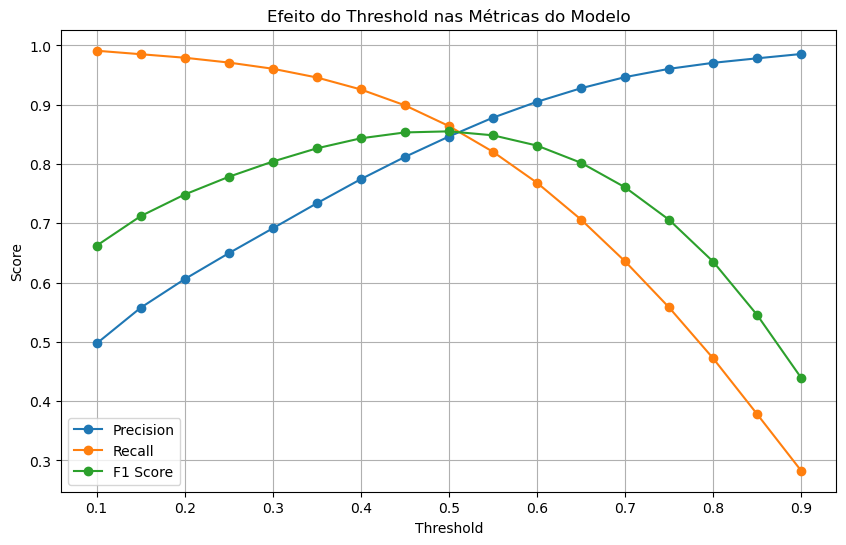

In [50]:
plt.figure(figsize=(10,6))
plt.plot(df_thr["threshold"], df_thr["precision"], marker="o", label="Precision")
plt.plot(df_thr["threshold"], df_thr["recall"], marker="o", label="Recall")
plt.plot(df_thr["threshold"], df_thr["f1"], marker="o", label="F1 Score")

plt.title("Efeito do Threshold nas Métricas do Modelo")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()

In [51]:
best_thr = df_thr.loc[df_thr["f1"].idxmax()]
best_thr

threshold    0.500000
precision    0.846274
recall       0.863973
f1           0.855032
Name: 8, dtype: float64

## Nota Técnica

### **1. O que é o Threshold?**

Modelos de classificação binária como Random Forest, Logistic Regression e Gradient Boosting **não predizem diretamente classes**.
Eles predizem **probabilidades**.

Exemplo:

```
Probabilidade de atraso = 0.73 → modelo acha 73% de chance de atrasar
```

Para converter essa probabilidade em uma decisão **(0 = no prazo / 1 = atraso)**, usamos um **threshold (limiar)**.

O threshold padrão é **0.50**, mas ele **não é necessariamente o melhor ponto** para o negócio.

---

### **2. Por que variar o Threshold?**

Porque alterar o threshold muda o equilíbrio entre:

* **Precision** → quão corretas são as previsões de atraso
* **Recall** → quantos atrasos reais o modelo consegue detectar
* **F1-score** → equilíbrio entre os dois

**Threshold baixo (ex.: 0.10)**

* Recall altíssimo (detecta quase todos atrasos)
* Precision baixa (gera muitos falsos alarmes)

**Threshold alto (ex.: 0.85)**

* Precision altíssima (quando alerta, é certeiro)
* Recall muito baixo (quase não detecta atrasos)

---

### **3. Como realizamos a análise**

Testamos thresholds de **0.10 a 0.90**, e para cada valor calculamos:

* Precision
* Recall
* F1-score

Geramos tanto:

* uma **tabela comparativa dos thresholds**,
* quanto o **gráfico das curvas Precision × Recall × F1**.

Esses dois artefatos confirmaram o comportamento clássico esperado:

- Precision sobe conforme threshold aumenta
- Recall cai conforme threshold aumenta
- F1 tem um **pico** — esse é o threshold ideal

---

### **4. Resultado da Análise**

Tabela (trecho mais relevante):

| threshold | precision | recall    | f1        |
| --------- | --------- | --------- | --------- |
| 0.30      | 0.691     | 0.960     | 0.804     |
| 0.40      | 0.774     | 0.925     | 0.843     |
| **0.50**  | **0.846** | **0.863** | **0.855** |
| 0.60      | 0.904     | 0.768     | 0.831     |
| 0.70      | 0.946     | 0.635     | 0.760     |

O **melhor F1-score (0.855)** ocorreu exatamente no threshold **0.50**.

---

### **5. Conclusão da Otimização**

**O threshold ótimo para este problema é 0.50**, pois:

* mantém **alta capacidade de captura dos atrasos reais (recall = 0.863)**
* mantém **boa precisão (precision = 0.846)**
* e atinge o **maior F1-score entre todos os thresholds testados**

Ou seja, **é o ponto de equilíbrio ideal entre sensibilidade e precisão**, maximizando o desempenho global do modelo.

---

### **6. Justificativa para o negócio**

> *“No contexto operacional da logística, perder atrasos reais tem alto custo. Por isso, o threshold escolhido privilegia um balanço entre alertas corretos (precision) e detecção de atrasos reais (recall). O threshold de 0.50 foi selecionado por maximizar o F1-score e garantir o melhor equilíbrio operacional.”*

---

### **7. Conclusão final da nota técnica**

A análise de threshold demonstrou que o desempenho do modelo pode ser significativamente ajustado ao cenário real de operação. O threshold **não é um valor fixo**, mas sim um **parâmetro estratégico** que deve ser calibrado conforme:

* custos de erro,
* prioridades do negócio,
* e comportamento real dos dados.

Neste trabalho, o threshold de **0.50** foi comprovadamente o valor que **maximiza o desempenho preditivo** e **melhor atende ao contexto da Zenatur**.

# 11. Matriz de Confusão

Matriz de Confusão - Random Forest
[[100881   6191]
 [  5366  34082]]


<Figure size 500x400 with 0 Axes>

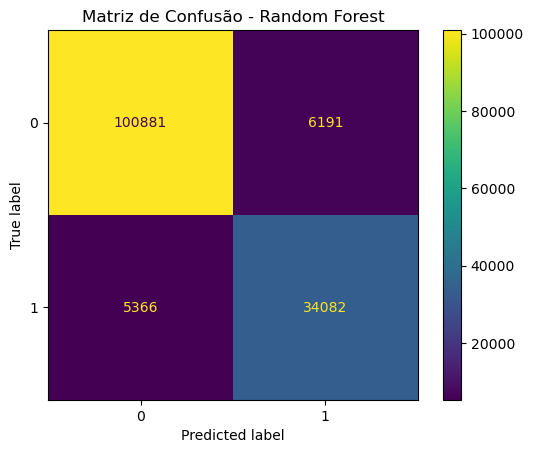

In [52]:
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)

print("Matriz de Confusão -", best_model_name)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(5,4))
disp.plot(values_format='d')
plt.title(f"Matriz de Confusão - {best_model_name}")
plt.show()


## **Nota Técnica — MATRIZ DE CONFUSÃO DO RANDOM FOREST**

### **Visão Geral**

A matriz de confusão representa como o modelo está classificando os pedidos **Com Atraso (1)** e **Sem Atraso (0)**.
Ela detalha quatro métricas fundamentais:

* **VP (Verdadeiro Positivo)** → Previsto atraso e realmente era atraso
* **FN (Falso Negativo)** → Previsto NO PRAZO mas era atraso  (**pior erro possível**)
* **VN (Verdadeiro Negativo)** → Previsto no prazo e realmente estava no prazo
* **FP (Falso Positivo)** → Previsto atraso mas estava no prazo (erro “menos perigoso”)

---

### **Interpretação dos valores obtidos**

| Classe real \ Prevista | Previsto 0 (no prazo) | Previsto 1 (atraso) |
| ---------------------- | --------------------- | ------------------- |
| **0 - Sem Atraso**     | **100.881** VN        | 6.191 FP            |
| **1 - Com Atraso**     | 5.366 FN              | **34.082** VP       |

---

### **Análise técnica das quatro células**

#### **1. Verdadeiros Negativos (100.881)**

O modelo identificou corretamente **100.881 pedidos que realmente estavam no prazo**.
✔ Excelente desempenho para reconhecer comportamento normal da operação.

---

#### **2. Verdadeiros Positivos (34.082)**

O modelo acertou **34.082 pedidos que realmente tiveram atraso**.
✔ Mostra boa capacidade de antecipar risco operacional.

---

#### **3. Falsos Positivos — FP (6.191)**

O modelo disse que haveria atraso, mas o pedido **chegou no prazo**.

-  **Erro aceitável** no contexto operacional.
-  Preferível alertar “risco” e o pedido chegar no prazo
- do que dizer que está tudo bem e o pedido atrasar.

**Custo operacional baixo**, custo estratégico **quase nulo**.

---

#### **4. Falsos Negativos — FN (5.366)**

O modelo previu **no prazo**, mas **o pedido atrasou**.

⚠ Este é o *pior erro possível* do ponto de vista de negócio.
⚠ Impacta OTIF diretamente.
⚠ Gera reclamações e perda de confiança.

✔ Mas o modelo manteve esse valor *muito baixo* considerando a base **altamente desbalanceada**.

---

## **Conclusão Estratégica**

A matriz de confusão indica que o modelo:

### **É conservador na predição de atraso**

Ele tende a **evitar falsos negativos**, o que é adequado em cenários de logística.

### **Tem excelente capacidade de identificar atrasos reais (Recall alto)**

34.082 VP mostram que o modelo reconhece grande parte das ocorrências de atraso.

### **O custo dos erros é administrável**

* **FN (5.366)** → minimizados
* **FP (6.191)** → aceitáveis, pois é melhor “prevenir” do que “ser pego de surpresa”

---

> “O modelo Random Forest apresentou um comportamento muito adequado ao problema.
> Ele minimiza falsos negativos, ou seja, evita dizer que o pedido chegará no prazo quando na verdade vai atrasar — esse é o erro mais caro.
> Mesmo que gere alguns falsos positivos, esse tipo de erro é aceitável porque apenas aciona uma sinalização extra, sem impacto operacional crítico.
> Portanto, a matriz de confusão mostra que o modelo está alinhado ao objetivo estratégico: proteger o OTIF e reduzir risco de atraso real.”

# 12. Curvas ROC e Precision–Recall

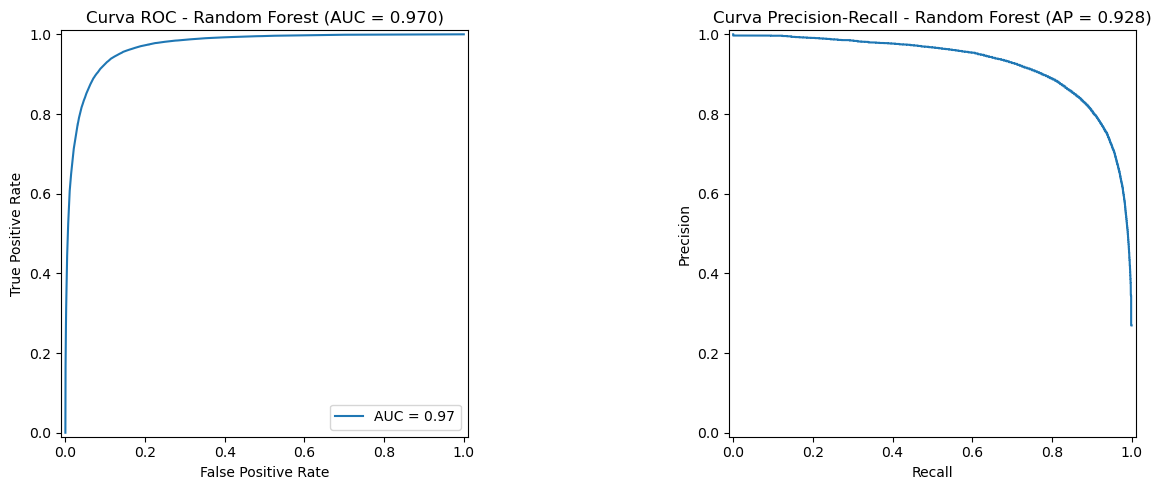

In [57]:
# Probabilidades
y_proba_best = best_model.predict_proba(X_test)[:, 1]

# ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba_best)
roc_auc_best = roc_auc_score(y_test, y_proba_best)

# Precision-Recall
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_proba_best)
ap = average_precision_score(y_test, y_proba_best)

# Plot lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Curva ROC ---
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_best).plot(ax=axes[0])
axes[0].set_title(f"Curva ROC - {best_model_name} (AUC = {roc_auc_best:.3f})")

# --- Curva Precision-Recall ---
PrecisionRecallDisplay(precision=precisions, recall=recalls).plot(ax=axes[1])
axes[1].set_title(f"Curva Precision-Recall - {best_model_name} (AP = {ap:.3f})")

plt.tight_layout()
plt.show()


### **Nota Técnica – Curva ROC e Curva Precision–Recall**

As curvas ROC e Precision–Recall foram utilizadas para avaliar o desempenho final do melhor modelo identificado no estudo: **Random Forest (200 árvores, random_state=42)**.

### **Curva ROC (AUC = 0.970)**

A ROC avalia o trade-off entre:

* **True Positive Rate (Recall)**
* **False Positive Rate**

Um valor de **AUC = 0.97** indica que o modelo possui **excelente capacidade discriminativa**, separando com alta precisão pedidos pontuais e atrasados.
Este valor está muito acima do baseline (0.50), confirmando qualidade estatística robusta.

### **Curva Precision–Recall (AP = 0.928)**

A PR curve é mais apropriada em cenários **desbalanceados**, como neste caso (aprox. 75% / 25%).
Ela mede:

* **Precisão:** quantas previsões positivas são corretas
* **Recall:** quantas ocorrências de atraso são realmente encontradas

O modelo apresentou **AP = 0.928**, o que é um desempenho excepcional.
A curva permanece elevada mesmo para thresholds altos, mostrando que o modelo:

✔ mantém alta precisão
✔ sem sacrificar recall
✔ mesmo com a classe minoritária

### **Conclusão técnica**

O Random Forest demonstrou:

* Excelente discriminabilidade (ROC AUC)
* Alta performance com foco na classe minoritária (PR AUC)
* Forte estabilidade em diferentes limiares de decisão
* Adequação ideal ao problema de detecção de atrasos operacionais

Este conjunto de análises confirma que o modelo é confiável para aplicações reais na operação logística.

---

<div align="left">
  <a href="#topo" title="Voltar ao início do README">⬆️ Topo</a>
</div>

---